# LEGO Minifigures Classification

## Data
The dataset is a collection of images of various Lego minifigures. Each image is 512x512 pixels and there are 37 classes. 

In [1]:
import os
import math
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image

seed = 1234
np.random.seed(seed)

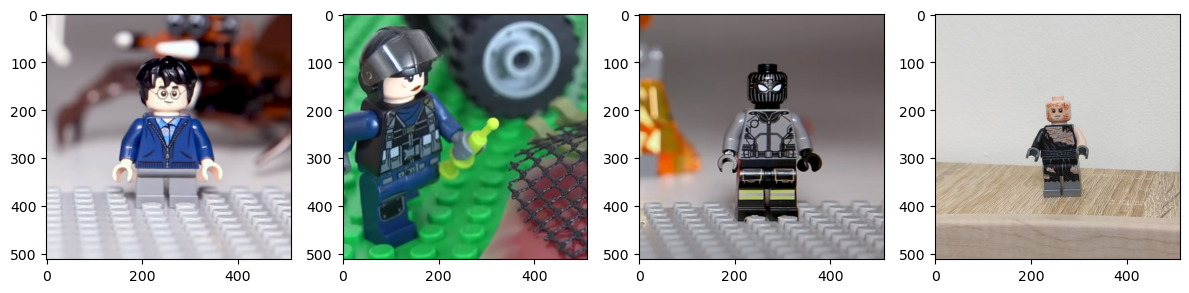

In [2]:
# Example of input images

image1 = np.asarray(Image.open('/kaggle/input/lego-minifigures-classification/harry-potter/0001/002.jpg'))
image2 = np.asarray(Image.open('/kaggle/input/lego-minifigures-classification/jurassic-world/0002/002.jpg'))
image3 = np.asarray(Image.open('/kaggle/input/lego-minifigures-classification/marvel/0007/002.jpg'))
image4 = np.asarray(Image.open('/kaggle/input/lego-minifigures-classification/star-wars/0014/002.jpg'))

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].imshow(image1)
axs[1].imshow(image2)
axs[2].imshow(image3)
axs[3].imshow(image4)

plt.tight_layout()
plt.show()

In [3]:
# Make training and validation sets
# Training is 80% and validation is 20% of the input

import pandas as pd
import sklearn.model_selection

kaggle_path = "/kaggle/input/lego-minifigures-classification/"
index_path = kaggle_path+"index.csv"

index = pd.read_csv(index_path)
targets = index["class_id"].values

train, valid = sklearn.model_selection.train_test_split(index, train_size=0.8, random_state = seed, stratify=targets)
train_X = [kaggle_path+p for p in train["path"].values]
train_y = train["class_id"].values
valid_X = [kaggle_path+p for p in valid["path"].values]
valid_y = valid["class_id"].values
print("Train size:", len(train_y))
print("Validation size:", len(valid_y))

Train size: 296
Validation size: 75


In [4]:
# Labels

# metadata.csv in lego-minifigures-classification has ` instead of ' which creates an error
# metadata_path = kaggle_path+"metadata.csv"
# metadata = pd.read_csv(metadata_path)

import codecs
f = codecs.open("/kaggle/input/lego-metadata/metadata_neeraj.csv", 'r', encoding='utf-8')
metadata = f.read()
labels = metadata[3]

In [5]:
# Tests
test_path = kaggle_path+"test.csv"
test = pd.read_csv(test_path)
test_X = test["path"].values
test_y = test["class_id"].values
print("Test size:", len(test_y))

Test size: 79


## CNN

In [6]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
torch.manual_seed(seed)

class LegoDataset(Dataset):
    def __init__(self, train = False, valid = False, test = False, transform=None):
        self.data, self.labels = None, None
        if train:
            self.data = train_X
            self.labels = train_y
        if valid:
            self.data = valid_X
            self.labels = valid_y
        if test:
            self.data = test_X
            self.labels = test_y
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = np.copy(np.asarray(Image.open(self.data[idx])))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
train_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
#     transforms.RandomResizedCrop(500),  # Randomly crop the image and resize it to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by 10 degrees
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.0),  # Adjust color jitter
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
#     transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = LegoDataset(train = True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

validset = LegoDataset(valid = True, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = LegoDataset(test = True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

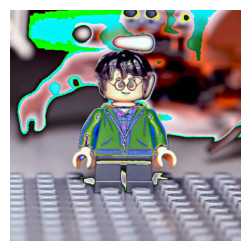

In [8]:
# Normal Tensor
image = Image.open('/kaggle/input/lego-minifigures-classification/harry-potter/0001/002.jpg')
augmented_image = transform(image)
fig, axes = plt.subplots(1, 1, figsize=(3, 3))

# Display the augmented image
plt.imshow(transforms.ToPILImage()(augmented_image))
plt.axis('off')
plt.show()

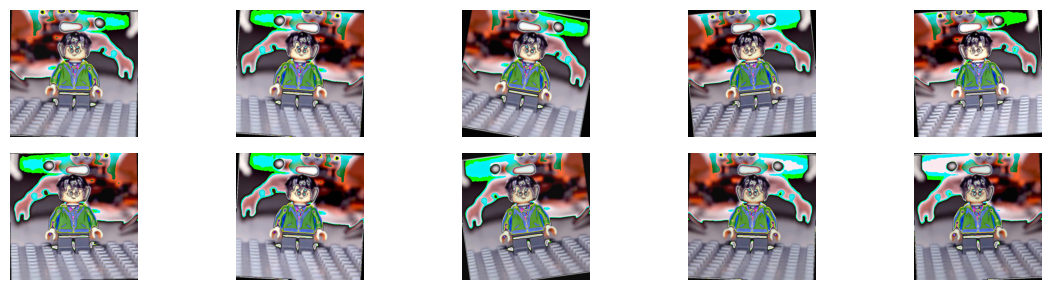

In [9]:
## Data Augmentation
image = Image.open('/kaggle/input/lego-minifigures-classification/harry-potter/0001/002.jpg')
fig, axes = plt.subplots(2, 5, figsize=(12, 3))

for i in range(5):
    for j in range(2): 
        augmented_image = train_transform(image)
        axes[j,i].imshow(transforms.ToPILImage()(augmented_image))
        axes[j,i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 32, 5)
        self.fc1 = nn.Linear(500000, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 39)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
print(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

cuda:0


In [12]:
for epoch in range(100):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i == 73:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 74:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    74] loss: 3.676
[2,    74] loss: 3.646
[3,    74] loss: 3.583
[4,    74] loss: 3.481
[5,    74] loss: 3.286
[6,    74] loss: 3.021
[7,    74] loss: 2.733
[8,    74] loss: 2.207
[9,    74] loss: 2.128
[10,    74] loss: 1.806
[11,    74] loss: 1.584
[12,    74] loss: 1.486
[13,    74] loss: 1.138
[14,    74] loss: 1.080
[15,    74] loss: 1.042
[16,    74] loss: 0.823
[17,    74] loss: 0.760
[18,    74] loss: 1.202
[19,    74] loss: 0.896
[20,    74] loss: 0.806
[21,    74] loss: 0.762
[22,    74] loss: 0.716
[23,    74] loss: 0.831
[24,    74] loss: 0.881
[25,    74] loss: 0.722
[26,    74] loss: 0.859
[27,    74] loss: 0.738
[28,    74] loss: 0.466
[29,    74] loss: 0.457
[30,    74] loss: 0.400
[31,    74] loss: 0.902
[32,    74] loss: 0.453
[33,    74] loss: 0.161
[34,    74] loss: 0.684
[35,    74] loss: 0.610
[36,    74] loss: 0.362
[37,    74] loss: 0.485
[38,    74] loss: 0.267
[39,    74] loss: 0.627
[40,    74] loss: 0.241
[41,    74] loss: 0.395
[42,    74] loss: 0.412
[

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on training images: {100 * correct // total} %')

Accuracy of the network on training images: 93 %


In [14]:
correct = 0
total = 0
labels_all = []
pred_all = []
with torch.no_grad():
    for data in validloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
#         print("Correct:",labels,"Predicted:",predicted)
#         labels_all = np.append(labels_all, labels)
#         pred_all = np.append(pred_all, predicted)

print(f'Accuracy of the network on validation images: {100 * correct // total} %')

Accuracy of the network on validation images: 38 %


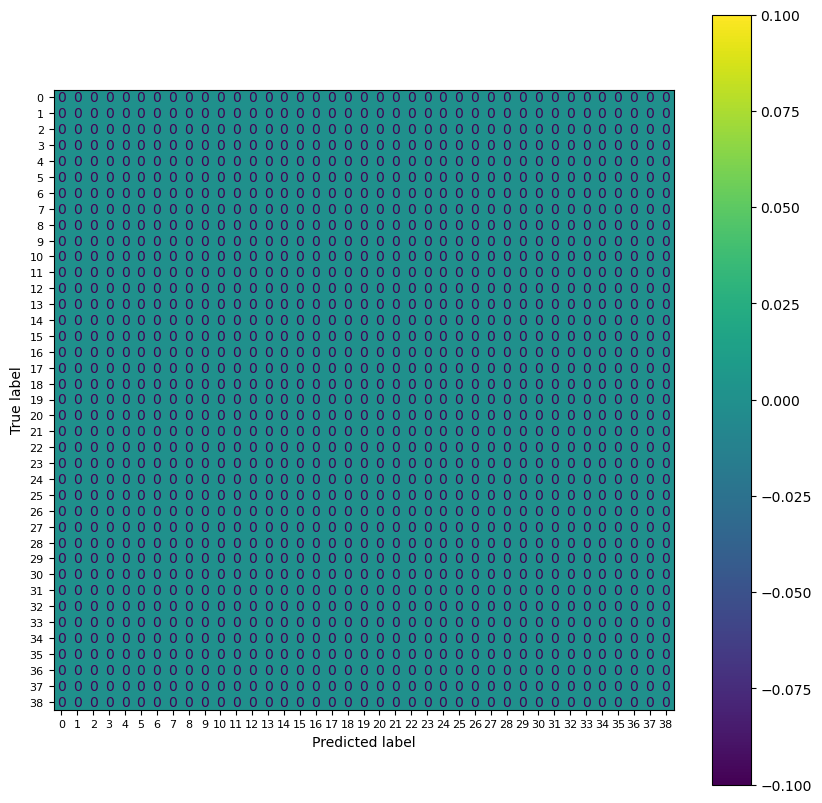

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,10))
cfm = ConfusionMatrixDisplay.from_predictions(labels_all, pred_all, ax=ax, labels=range(39))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()